In [71]:
import neptune as neptune
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# functions

In [72]:
def get_neptune_table(tags, negative_tags=None):
    project = neptune.init_project(
        project="pmtest/llm-random",
        mode="read-only",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyMDY0ZDI5Ni05YWU3LTQyNGYtYmY4My1hZTFkY2EzYmUwMjgifQ=="
    )
    runs_table = project.fetch_runs_table(tag=tags).to_pandas()
    runs_table['sys/tags'] = runs_table['sys/tags'].apply(lambda x: x.split(',') if isinstance(x, str) else x)

    # If negative tags are provided, filter them out
    if negative_tags is not None:
        for neg_tag in negative_tags:
            runs_table = runs_table[~runs_table['sys/tags'].apply(lambda x: neg_tag in x)]

    print(f'table downloaded\nshape: {runs_table.shape}')
    return runs_table


In [73]:
def get_neptune_table_by_ids(run_ids):
    project = neptune.init_project(
        project="pmtest/llm-random",
        mode="read-only",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyMDY0ZDI5Ni05YWU3LTQyNGYtYmY4My1hZTFkY2EzYmUwMjgifQ=="
    )
    
    runs_table = project.fetch_runs_table(id=run_ids).to_pandas()
    
    print(f'table downloaded by IDs\nshape: {runs_table.shape}')
    return runs_table


In [74]:
def get_loss_per_step(runs_table):
    loss_dict = {}
    for _, run_row in runs_table.iterrows():
        run_id = run_row['sys/id']  # Assuming 'sys/id' is the run identifier
        print(f'run ID: {run_id}')
        project_name = "pmtest/llm-random"
        # run_id = "LLMRANDOM-2078"
        run = neptune.init_run(
            project=project_name,
            with_id=run_id,
            mode="read-only",
            api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyMDY0ZDI5Ni05YWU3LTQyNGYtYmY4My1hZTFkY2EzYmUwMjgifQ==",
        )
        loss_dict[run_id] = run[f"loss_interval/1"].fetch_values()
    return loss_dict

def df_per_step(df, per_step):
    # Calculate the rolling average of 'value' column with window size `per_step`
    df['value'] = df['value'].rolling(window=per_step, min_periods=1).mean()
    
    # Select every `per_step`-th row from the end backwards, excluding the first step
    selected_indices = list(range(len(df) - 1, 0, -per_step))  # Start from second last to skip the first step
    selected_rows = df.iloc[selected_indices]
    
    # Sort the selected rows to maintain ascending step order
    selected_rows = selected_rows.sort_index()
    
    return selected_rows

In [136]:
def calculate_speedup(total, faster):
    speedup_1 = (total - faster) / total
    speedup_2 = (total - faster) / faster
    speedup_3 = total / faster
    
    return speedup_1, speedup_2, speedup_3

In [137]:
def plot_std(runs_spec_type, runs_1, runs_2, title, name_1, name_2, show_plot=False, save_to=None, figsize=(10, 10), ylim=None, x_start=None, loss_per=100):
    b_v_r_negative_tags = ['remove']
    if runs_spec_type == 'tags':
        table_1 = get_neptune_table(runs_1, b_v_r_negative_tags)
        table_2 = get_neptune_table(runs_2, b_v_r_negative_tags)
    elif runs_spec_type == 'ids':
        table_1 = get_neptune_table_by_ids(runs_1)
        table_2 = get_neptune_table_by_ids(runs_2)
    loss_dict_1 = get_loss_per_step(table_1)
    loss_dict_2 = get_loss_per_step(table_2)
    
    # Concatenate the dataframes into one
    df_1 = pd.concat([df.set_index('step')['value'] for df in loss_dict_1.values()], axis=1)
    df_1 = df_per_step(df_1, loss_per)
    df_2 = pd.concat([df.set_index('step')['value'] for df in loss_dict_2.values()], axis=1)
    df_2 = df_per_step(df_2, loss_per)

    # Calculate mean and standard deviation
    df_1['mean'] = df_1.mean(axis=1)
    df_1['std'] = df_1.std(axis=1)

    # Calculate mean and standard deviation
    df_2['mean'] = df_2.mean(axis=1)
    df_2['std'] = df_2.std(axis=1)

    # Reset the index to have 'step' as a column again
    df_1 = df_1[['mean', 'std']].reset_index()
    df_2 = df_2[['mean', 'std']].reset_index()

    if show_plot:
        # Create the plot
        plt.figure(figsize=figsize)

        # baseline
        steps = df_1['step'].values
        mean_values = df_1['mean'].values
        std_values = df_1['std'].values

        if x_start is not None:
            first_index = np.argmax(steps > x_start)
            steps = steps[first_index:]
            mean_values = mean_values[first_index:]
            std_values = std_values[first_index:]

        plt.plot(steps, mean_values, label=f'{name_1} - mean', color='blue')
        plt.fill_between(steps, mean_values - std_values, mean_values + std_values, 
                        color='blue', alpha=0.2, label=f'{name_1} - standard deviation')

        #relative
        steps = df_2['step'].values
        mean_values = df_2['mean'].values
        std_values = df_2['std'].values

        if x_start is not None:
            steps = steps[first_index:]
            mean_values = mean_values[first_index:]
            std_values = std_values[first_index:]

        plt.plot(steps, mean_values, label=f'{name_2} - mean', color='red')
        plt.fill_between(steps, mean_values - std_values, mean_values + std_values, 
                        color='red', alpha=0.2, label=f'{name_2} - standard deviation')

        # # Plot individual dataframes from the dictionary
        # for run_id, df in relative_loss_dict.items():
        #     plt.plot(df['step'].values, df['value'].values, label=f'Run {run_id}')

        # Add labels and title
        plt.xlabel('Step')
        plt.ylabel('Loss')
        if ylim is not None:
            plt.ylim(ylim)
        plt.title(title)

        # Show legend
        plt.legend()
        if save_to is not None:
            plt.savefig(save_to)
        # Show the plot
        plt.show()

    # For baseline_df: Find the last step and the loss at that step
    last_step_baseline = df_1['step'].values[-1]
    loss_baseline = df_1['mean'].values[-1]
    std_baseline = df_1['std'].values[-1]
    
    # For relative_df: Find the first step where the mean loss is smaller than baseline's last mean loss
    smaller_loss_condition = df_2['mean'] < loss_baseline

    if smaller_loss_condition.any():  # Check if there's any step with a smaller mean loss
        first_smaller_step_relative = df_2[smaller_loss_condition]['step'].values[0]
        loss_relative = df_2['mean'].values[-1]
        std_relative = df_2['std'].values[-1]
        speedup_1, speedup_2, speedup_3 = calculate_speedup(total=last_step_baseline, faster=first_smaller_step_relative)
    else:
        # No step has a smaller mean loss
        first_smaller_step_relative = None
        loss_relative = None
        std_relative = None
        speedup_1, speedup_2, speedup_3 = None, None, None

    return (last_step_baseline, loss_baseline, std_baseline), (first_smaller_step_relative, loss_relative, std_relative), (speedup_1, speedup_2, speedup_3)

In [138]:
def results_dict_append(component_name, baseline, relative, speedup, results_dict=None):
    # Unpack the tuples for easier readability
    (last_step_baseline, loss_baseline, std_baseline), (first_smaller_step_relative, loss_relative, std_relative), (speedup_1, speedup_2, speedup_3) = baseline, relative, speedup
    
    # Check if results_dict is None and initialize if necessary
    if results_dict is None:
        results_dict = {
            'component': [],
            'total_tokens': [],
            'faster_tokens': [],
            'speedup (1-(a/b))': [],
            'speedup ((b-a)/b)': [],
            'speedup (b/a)': [],
        }

    # Calculate values to be added to the table
    total_tokens = last_step_baseline
    faster_tokens = first_smaller_step_relative if first_smaller_step_relative is not None else "N/A"
    speedup_1_val = speedup_1 if speedup_1 is not None else "N/A"
    speedup_2_val = speedup_2 if speedup_2 is not None else "N/A"
    speedup_3_val = speedup_3 if speedup_3 is not None else "N/A"
    
    # Append results to the dictionary
    results_dict['component'].append(component_name)
    results_dict['total_tokens'].append(total_tokens)
    results_dict['faster_tokens'].append(faster_tokens)
    results_dict['speedup (1-(a/b))'].append(speedup_1_val)
    results_dict['speedup ((b-a)/b)'].append(speedup_2_val)
    results_dict['speedup (b/a)'].append(speedup_3_val)
    
    return results_dict


In [139]:
def plot_std_component(table, component_name, start_end, ax=None):
    print(f'component_name: {component_name}, start_end: {start_end}')
    # Define the relevant column for grouping and analysis
    se_convert = {
        'start': 'relative_lr',
        'end': 'relative_scheduler_fraction'
    }
    dict_name = se_convert[start_end]
    args_column = f'args/{dict_name}/{component_name}'
    
    # Filter the table based on the presence of both component_name and start_end in the tags
    filtered_table = table[table['sys/tags'].apply(lambda tags: component_name in tags and start_end in tags)]
    print(f'filtered_table: {filtered_table.shape}')
    # add optimal table
    optimal_table = table[table['sys/tags'].apply(lambda tags: 'relative' in tags)]
    print(f'optimal_table: {optimal_table.shape}')

    # Select the relevant columns
    columns = ['loss', args_column]
    # if component_name == "embedding_layer" and start_end == "start":
    #     print(f'shape: {filtered_table.shape}')
    #     print(f'optimal table:\n{filtered_table[columns].sort_values(args_column)}')
    filtered_table = filtered_table[columns]

    x_1_table = filtered_table[filtered_table[args_column] == 1]
    filtered_table = filtered_table[filtered_table[args_column] != 1]

    # Group the data by the `args_column` and calculate mean, min, and max of the `loss` column
    grouped_data = filtered_table.groupby(args_column)['loss'].agg(['mean', 'min', 'max']).reset_index()
    x_1_data = x_1_table.groupby(args_column)['loss'].agg(['mean', 'min', 'max']).reset_index()
    optimal_grouped = optimal_table.groupby(args_column)['loss'].agg(['mean', 'min', 'max']).reset_index()

    # Create a new axis if one is not provided
    if ax is None:
        fig, ax = plt.subplots()

    # Convert x_values to a NumPy array for errorbar plot
    x_values = np.round(grouped_data[args_column].values, 2)
    x_1_values = np.round(x_1_data[args_column].values, 2)
    x_optimal = np.round(optimal_grouped[args_column].values, 2)

    # Calculate yerr as the difference between the mean and min/max
    yerr = np.vstack([grouped_data['mean'] - grouped_data['min'], grouped_data['max'] - grouped_data['mean']])
    x_1_yerr = np.vstack([x_1_data['mean'] - x_1_data['min'], x_1_data['max'] - x_1_data['mean']])
    optimal_yerr = np.vstack([optimal_grouped['mean'] - optimal_grouped['min'], optimal_grouped['max'] - optimal_grouped['mean']])

    # Plot using errorbar
    ax.errorbar(x=x_values, y=grouped_data['mean'], yerr=yerr, fmt='o', color='blue', label='Other relative', capsize=5)
    ax.errorbar(x=x_1_values, y=x_1_data['mean'], yerr=x_1_yerr, fmt='o', color='red', label='Baseline (no relative)', capsize=5)
    ax.errorbar(x=x_optimal, y=optimal_grouped['mean'], yerr=optimal_yerr, fmt='o', color='green', label='Optimal relative', capsize=5)

    # Set the x-axis to a log scale
    ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_xlabel(args_column)
    ax.set_ylabel('Loss')
    ax.set_title(f'Mean Loss with Error Bars for {component_name} ({start_end})')

    # Customize x-axis tick labels to display as regular numbers
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

    # Set the major ticks to match the x-values in the data
    x_values = np.concatenate((x_values, x_1_values, x_optimal))
    ax.set_xticks(x_values)
    print(f'x_values: {x_values}')

    # Add gridlines for minor ticks
    ax.grid(True, which='major', linestyle='--', linewidth=0.5)

    # Add legend
    ax.legend()

    # Show the plot only if `ax` is not provided
    if ax is None:
        plt.show()


In [140]:
def U_plot(model_name, tags, negative_tags, component_names, start_ends, ylim=(3, 4)):
    u_plot_table = get_neptune_table(tags=tags, negative_tags=negative_tags)
    print(f'there are {u_plot_table.shape[0]} runs')
    
    # Create subplots with 2 rows and 5 columns
    fig, axs = plt.subplots(len(component_names), len(start_ends), sharey=True, figsize=(10, 25))

    # Loop through components and start_ends
    for i, name in enumerate(component_names):
        for j, start_end in enumerate(start_ends):
            ax = axs[i, j]
            plot_std_component(table=u_plot_table, component_name=name, start_end=start_end, ax=ax)
            ax.set_title(f'{name} ({start_end})')
            for label in ax.get_xticklabels():
                label.set_rotation(45)

    for ax in axs.flat:
        ax.set_ylim((ylim))

    # Adjust layout to make room for labels
    plt.tight_layout()
    plt.savefig(f'U-plots-{model_name}.png')
    plt.show()

# NEW

## Main

### Medium (30M)

https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 364)
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 374)
run ID: LLMRANDOM-15777
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15777
run ID: LLMRANDOM-15776
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15776
run ID: LLMRANDOM-15775
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15775
run ID: LLMRANDOM-15780
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15780
run ID: LLMRANDOM-15779
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15779
run ID: LLMRANDOM-15778
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15778


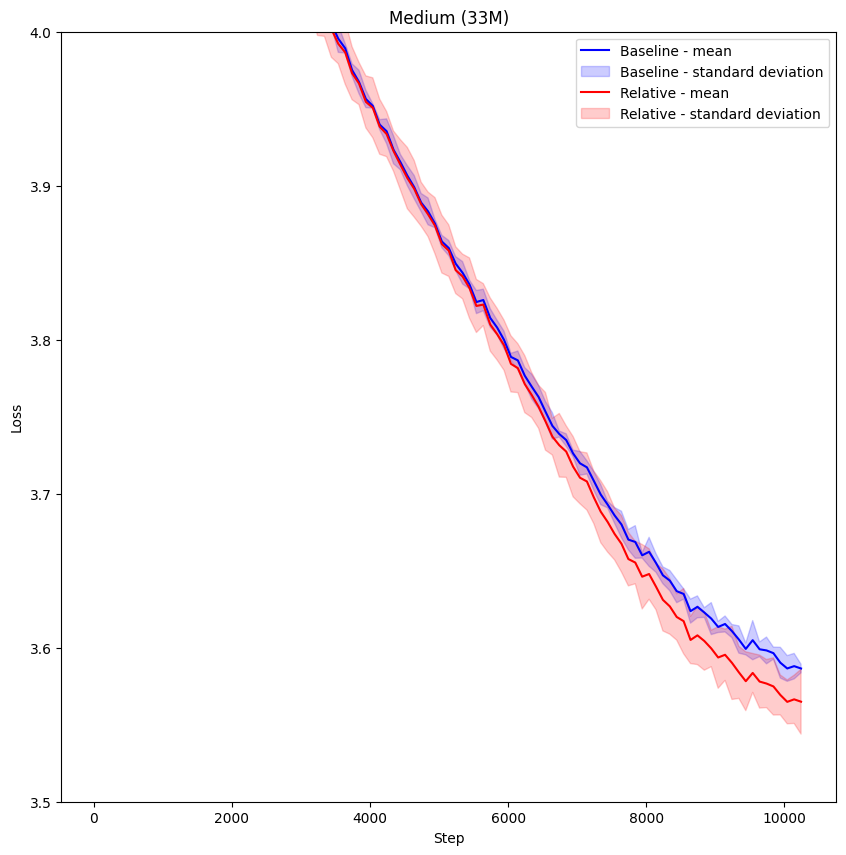

gain: 0.087890625
total tokens: 671.0M, relative tokens: 612.0M
std baseline: 0.0027851194213125304, std relative: 0.02103111682463607


In [112]:
b_v_r_tags_baseline = ['relativity_paper', 'medium_model', 'std', 'baseline']
b_v_r_tags_relative = ['relativity_paper', 'medium_model', 'std', 'relative']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), (gain, _, _) = plot_std(
    runs_spec_type='tags',
    runs_1=b_v_r_tags_baseline,
    runs_2=b_v_r_tags_relative,
    title='Medium (33M)',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='medium_relative_vs_baseline.png',
    ylim=(3.5, 4),
    x_start=0,
)

print(f'gain: {gain}')
tokens_per_step = 128 * 512
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000, 0)}M, relative tokens: {round(relative_steps * tokens_per_step / 1000000, 0)}M')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

### Base (100M)

https://app.neptune.ai/pmtest/llm-random/


table downloaded
shape: (3, 436)
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 446)
run ID: LLMRANDOM-15759
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15759
run ID: LLMRANDOM-15758
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15758
run ID: LLMRANDOM-15757
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15757
run ID: LLMRANDOM-15762
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15762
run ID: LLMRANDOM-15761
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15761
run ID: LLMRANDOM-15760
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15760


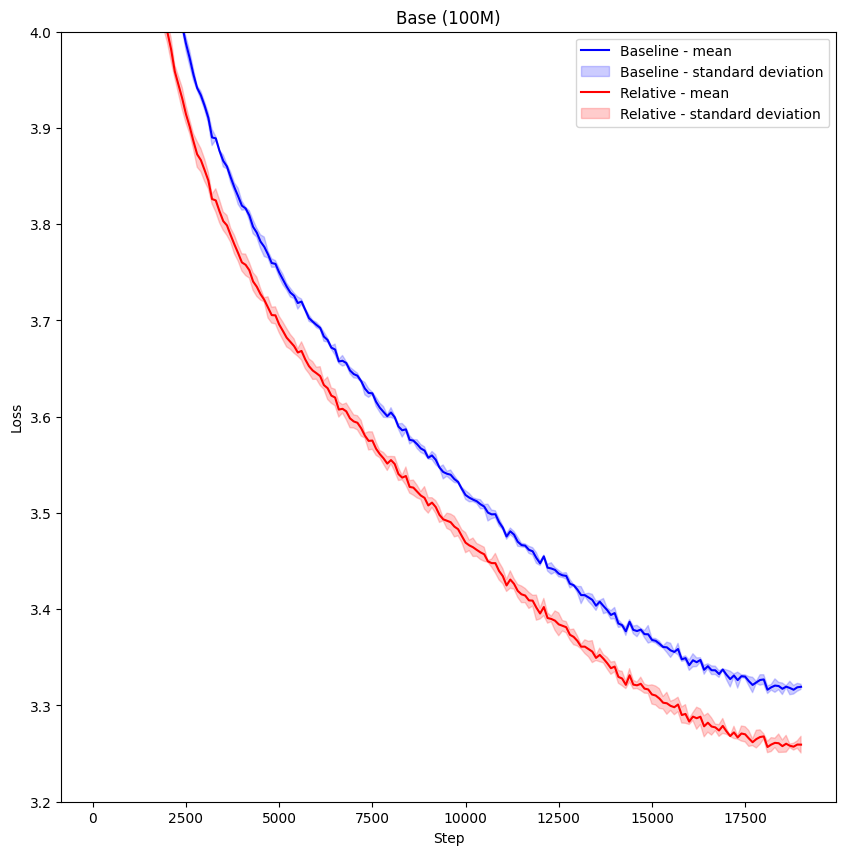

gain: 0.2210526315789474
total tokens: 1245.0M, relative tokens: 970.0M
std baseline: 0.0027185803746574474, std relative: 0.008685374096651544


In [113]:
b_v_r_tags_baseline = ['relativity_paper', 'base_model', 'std', 'baseline']
b_v_r_tags_relative = ['relativity_paper', 'base_model', 'std', 'relative']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), (gain, _, _) = plot_std(
    runs_spec_type='tags',
    runs_1=b_v_r_tags_baseline,
    runs_2=b_v_r_tags_relative,
    title='Base (100M)',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='base_relative_vs_baseline.png',
    ylim=(3.2, 4),
    x_start=0,
)

print(f'gain: {gain}')
tokens_per_step = 128 * 512
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000, 0)}M, relative tokens: {round(relative_steps * tokens_per_step / 1000000, 0)}M')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

### Large (1B)

## Ablations

### U-plots

#### Medium (30M)

https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (272, 3723)
there are 272 runs
component_name: embedding_layer, start_end: start
filtered_table: (26, 3723)
optimal_table: (3, 3723)
x_values: [ 0.62  0.83  1.25  2.5  10.   20.   30.   40.    1.    5.  ]
component_name: embedding_layer, start_end: end
filtered_table: (27, 3723)
optimal_table: (3, 3723)
x_values: [0.08 0.11 0.17 0.33 1.33 2.66 4.   5.33 1.   0.67]
component_name: head, start_end: start
filtered_table: (27, 3723)
optimal_table: (3, 3723)
x_values: [0.08 0.11 0.17 0.33 1.33 2.66 4.   5.33 1.   0.67]
component_name: head, start_end: end
filtered_table: (27, 3723)
optimal_table: (3, 3723)
x_values: [0.06 0.07 0.11 0.22 0.89 1.78 2.66 3.55 1.   0.44]
component_name: gating, start_end: start
filtered_table: (27, 3723)
optimal_table: (3, 3723)
x_values: [0.08 0.11 0.17 0.33 1.33 2.66 4.   5.33 1.   0.67]
component_name: gating, start_end: end
filtered_table: (27, 3723)
optimal_table: (3, 3723)
x_values: [0.12 0

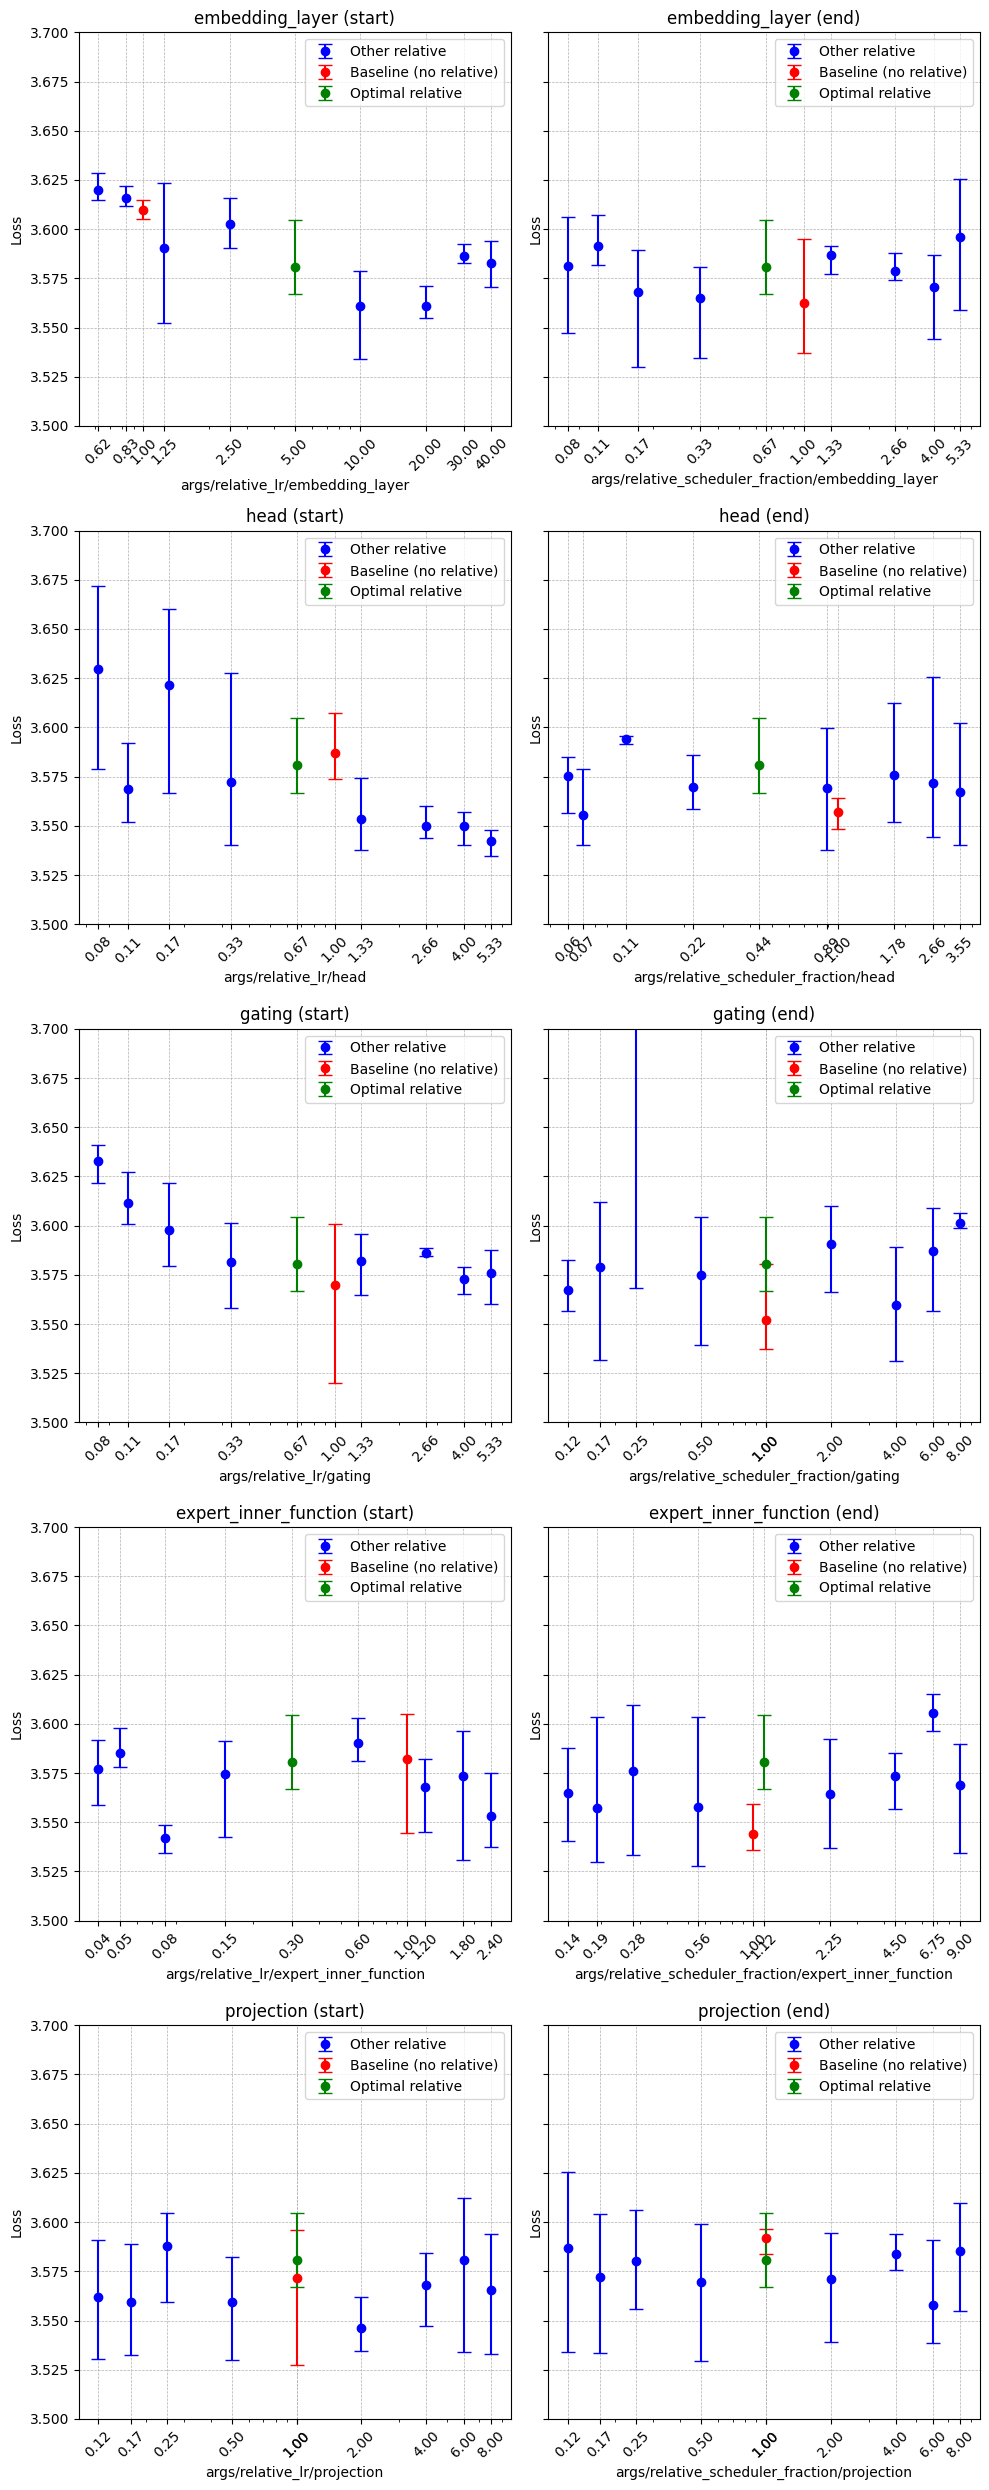

In [81]:
u_plot_tags = ['relativity_paper', 'medium_model', 'uplot']
u_plot_negative_tags = ['remove']

component_names = ['embedding_layer', 'head', 'gating', 'expert_inner_function', 'projection']
start_ends = ['start', 'end']
model_name = 'Medium (30M)'

U_plot(
    model_name=model_name,
    tags=u_plot_tags,
    negative_tags=u_plot_negative_tags,
    component_names=component_names,
    start_ends=start_ends,
    ylim=(3.5, 3.7)
)

#### Base (100M)

https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (153, 3911)
there are 153 runs
component_name: embedding_layer, start_end: start
filtered_table: (13, 3911)
optimal_table: (3, 3911)
x_values: [ 1.25  2.5  10.   20.    1.    5.  ]
component_name: embedding_layer, start_end: end
filtered_table: (15, 3911)
optimal_table: (3, 3911)
x_values: [0.17 0.33 1.33 2.66 1.   0.67]
component_name: head, start_end: start
filtered_table: (14, 3911)
optimal_table: (3, 3911)
x_values: [0.17 0.33 1.33 2.66 1.   0.67]
component_name: head, start_end: end
filtered_table: (15, 3911)
optimal_table: (3, 3911)
x_values: [0.11 0.22 0.89 1.78 1.   0.44]
component_name: gating, start_end: start
filtered_table: (14, 3911)
optimal_table: (3, 3911)
x_values: [0.17 0.33 1.33 2.66 1.   0.67]
component_name: gating, start_end: end
filtered_table: (14, 3911)
optimal_table: (3, 3911)
x_values: [0.25 0.5  2.   4.   1.   1.  ]
component_name: expert_inner_function, start_end: start
filtered_table: (15, 39

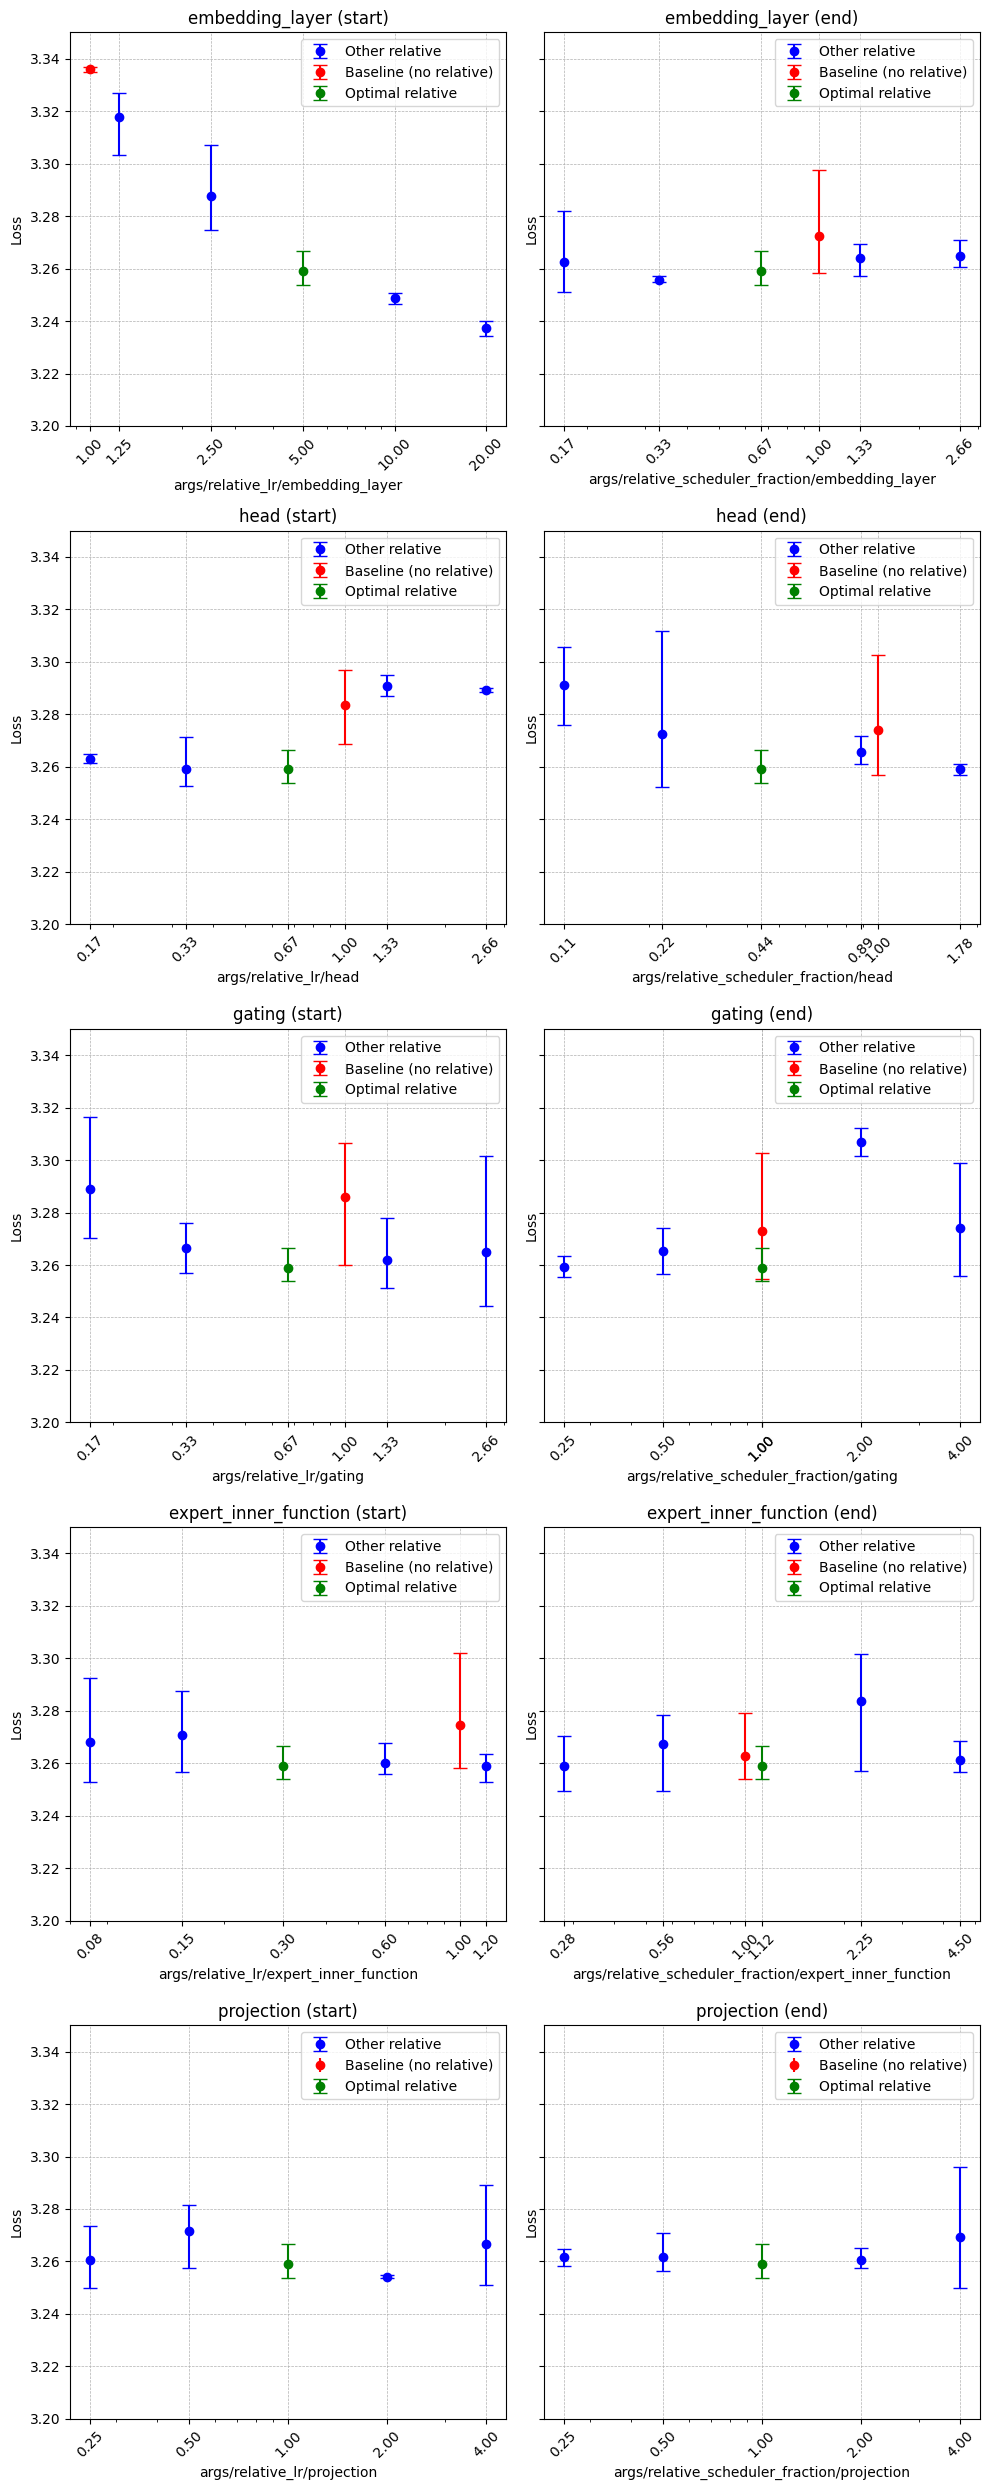

In [80]:
u_plot_tags = ['relativity_paper', 'base_model', 'uplot']
u_plot_negative_tags = ['remove']

component_names = ['embedding_layer', 'head', 'gating', 'expert_inner_function', 'projection']
start_ends = ['start', 'end']
model_name = 'Base (100M)'

U_plot(
    model_name=model_name,
    tags=u_plot_tags,
    negative_tags=u_plot_negative_tags,
    component_names=component_names,
    start_ends=start_ends,
    ylim=(3.2, 3.35)
)

### Component Removal

#### Medium (30M)

In [141]:
model_type = 'medium_model'

component_names = ['embedding_layer', 'head', 'gating', 'expert_inner_function']
tags_relative = ['relativity_paper', model_type, 'removal', 'relative']
results_dict = None

for component in component_names:
    print(f'component: {component}')
    tags_baseline = ['relativity_paper', model_type, 'removal', component]

    baseline, relative, speedup = plot_std(
        runs_spec_type='tags',
        runs_1=tags_baseline,
        runs_2=tags_relative,
        title='Medium (33M)',
        name_1='Baseline',
        name_2='Relative',
        show_plot=False,
        save_to=None,
        ylim=(3.5, 4),
        x_start=0,
    )

    results_dict = results_dict_append(component, baseline, relative, speedup, results_dict)

df = pd.DataFrame(results_dict)
print(df)
print()
print(df.to_latex())

component: embedding_layer
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 407)
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 374)
run ID: LLMRANDOM-15632
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15632
run ID: LLMRANDOM-15628
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15628
run ID: LLMRANDOM-15627
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15627
run ID: LLMRANDOM-15780
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15780
run ID: LLMRANDOM-15779
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15779
run ID: LLMRANDOM-15778
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15778
component: head
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 374)
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 374)
run ID: LLMRANDOM-15582
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15582
run ID: LLMRANDOM-15581
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM

#### Base (100M)

In [142]:
model_type = 'base_model'

component_names = ['embedding_layer', 'head', 'gating', 'expert_inner_function']
tags_relative = ['relativity_paper', model_type, 'removal', 'relative']
results_dict = None

for component in component_names:
    print(f'component: {component}')
    tags_baseline = ['relativity_paper', model_type, 'removal', component]

    baseline, relative, speedup = plot_std(
        runs_spec_type='tags',
        runs_1=tags_baseline,
        runs_2=tags_relative,
        title='Medium (33M)',
        name_1='Baseline',
        name_2='Relative',
        show_plot=False,
        save_to=None,
        ylim=(3.5, 4),
        x_start=0,
    )

    results_dict = results_dict_append(component, baseline, relative, speedup, results_dict)

df = pd.DataFrame(results_dict)
print(df)
print()
print(df.to_latex())

component: embedding_layer
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 446)
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 446)
run ID: LLMRANDOM-15597
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15597
run ID: LLMRANDOM-15596
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15596
run ID: LLMRANDOM-15595
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15595
run ID: LLMRANDOM-15762
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15762
run ID: LLMRANDOM-15761
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15761
run ID: LLMRANDOM-15760
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15760
component: head
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 446)
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 446)
run ID: LLMRANDOM-15606
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15606
run ID: LLMRANDOM-15605
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM

### Component Contribution

#### Medium (30M)

In [145]:
model_type = 'medium_model'

component_names = ['embedding_layer', 'head', 'gating', 'expert_inner_function']
tags_baseline = ['relativity_paper', model_type, 'contribution', 'baseline']
results_dict = None

for component in component_names:
    print(f'component: {component}')
    tags_relative = ['relativity_paper', model_type, 'contribution', component]

    baseline, relative, speedup = plot_std(
        runs_spec_type='tags',
        runs_1=tags_baseline,
        runs_2=tags_relative,
        title='Medium (33M)',
        name_1='Baseline',
        name_2='Relative',
        show_plot=False,
        save_to=None,
        ylim=(3.5, 4),
        x_start=0,
    )

    results_dict = results_dict_append(component, baseline, relative, speedup, results_dict)

df = pd.DataFrame(results_dict)
print(df)
print()
print(df.to_latex())

component: embedding_layer
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 364)
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 366)
run ID: LLMRANDOM-15777
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15777
run ID: LLMRANDOM-15776
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15776
run ID: LLMRANDOM-15775
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15775
run ID: LLMRANDOM-15585
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15585
run ID: LLMRANDOM-15584
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15584
run ID: LLMRANDOM-15583
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15583
component: head
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 364)
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 366)
run ID: LLMRANDOM-15777
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15777
run ID: LLMRANDOM-15776
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM

#### Base (100M)

In [146]:
model_type = 'base_model'

component_names = ['embedding_layer', 'head', 'gating', 'expert_inner_function']
tags_baseline = ['relativity_paper', model_type, 'contribution', 'baseline']
results_dict = None

for component in component_names:
    print(f'component: {component}')
    tags_relative = ['relativity_paper', model_type, 'contribution', component]

    baseline, relative, speedup = plot_std(
        runs_spec_type='tags',
        runs_1=tags_baseline,
        runs_2=tags_relative,
        title='Medium (33M)',
        name_1='Baseline',
        name_2='Relative',
        show_plot=False,
        save_to=None,
        ylim=(3.5, 4),
        x_start=0,
    )

    results_dict = results_dict_append(component, baseline, relative, speedup, results_dict)

df = pd.DataFrame(results_dict)
print(df)
print()
print(df.to_latex())

component: embedding_layer
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 436)
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 438)
run ID: LLMRANDOM-15759
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15759
run ID: LLMRANDOM-15758
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15758
run ID: LLMRANDOM-15757
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15757
run ID: LLMRANDOM-15609
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15609
run ID: LLMRANDOM-15608
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15608
run ID: LLMRANDOM-15607
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15607
component: head
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 436)
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 438)
run ID: LLMRANDOM-15759
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15759
run ID: LLMRANDOM-15758
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM

# OLD

## MoE

Example

https://app.neptune.ai/pmtest/llm-random/
table downloaded by IDs
shape: (1, 642)
https://app.neptune.ai/pmtest/llm-random/
table downloaded by IDs
shape: (1, 652)
run ID: LLMRANDOM-14973
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14973
run ID: LLMRANDOM-15082
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-15082


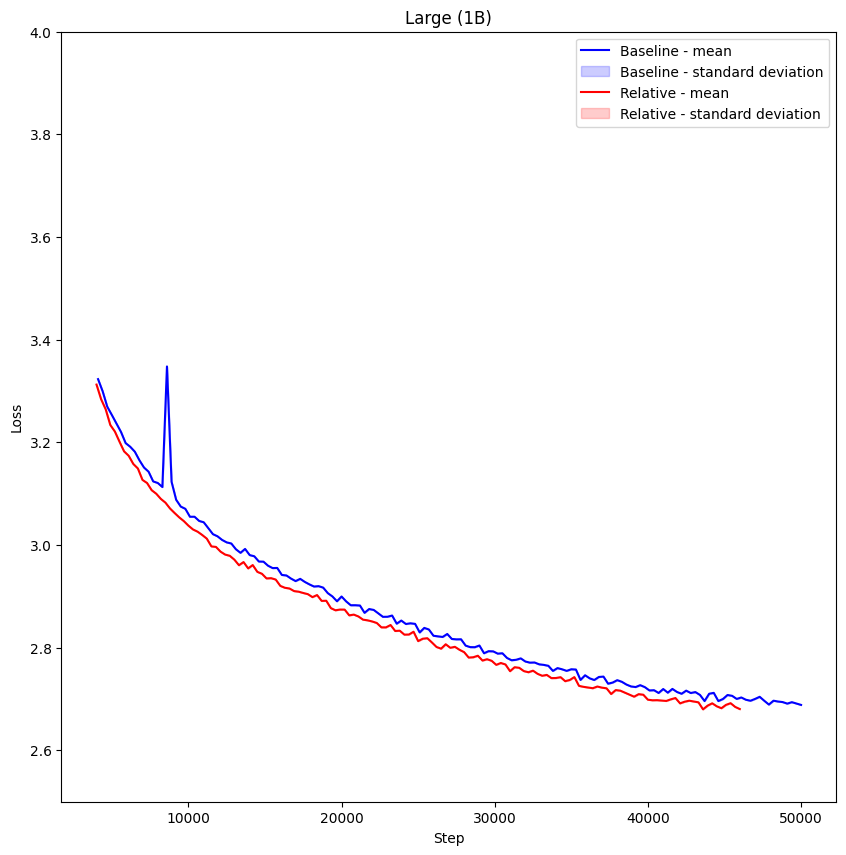

In [48]:
baseline_ids = ['LLMRANDOM-14973']
relative_ids = ['LLMRANDOM-15082']

# baseline_ids = ['LLMRANDOM-15731']
# relative_ids = ['LLMRANDOM-15731']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), gain = plot_std(
    runs_spec_type='ids',
    runs_1=baseline_ids,
    runs_2=relative_ids,
    title='Large (1B)',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='medium_relative_vs_baseline.png',
    ylim=(2.5, 4),
    x_start=4000,
    loss_per=300,
)

In [50]:
print(f'gain: {100 - gain}')
tokens_per_step = 384 * 1024
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000, 0)}M, relative tokens: {round(relative_steps * tokens_per_step / 1000000, 0)}M')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

gain: 12.799999999999997
total tokens: 19661.0M, relative tokens: 17144.0M
std baseline: 0.0, std relative: 0.0


### Medium

https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 368)
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 368)
run ID: LLMRANDOM-13676
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13676
run ID: LLMRANDOM-13675
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13675
run ID: LLMRANDOM-13544
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13544
run ID: LLMRANDOM-13677
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13677
run ID: LLMRANDOM-13674
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13674
run ID: LLMRANDOM-13563
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13563


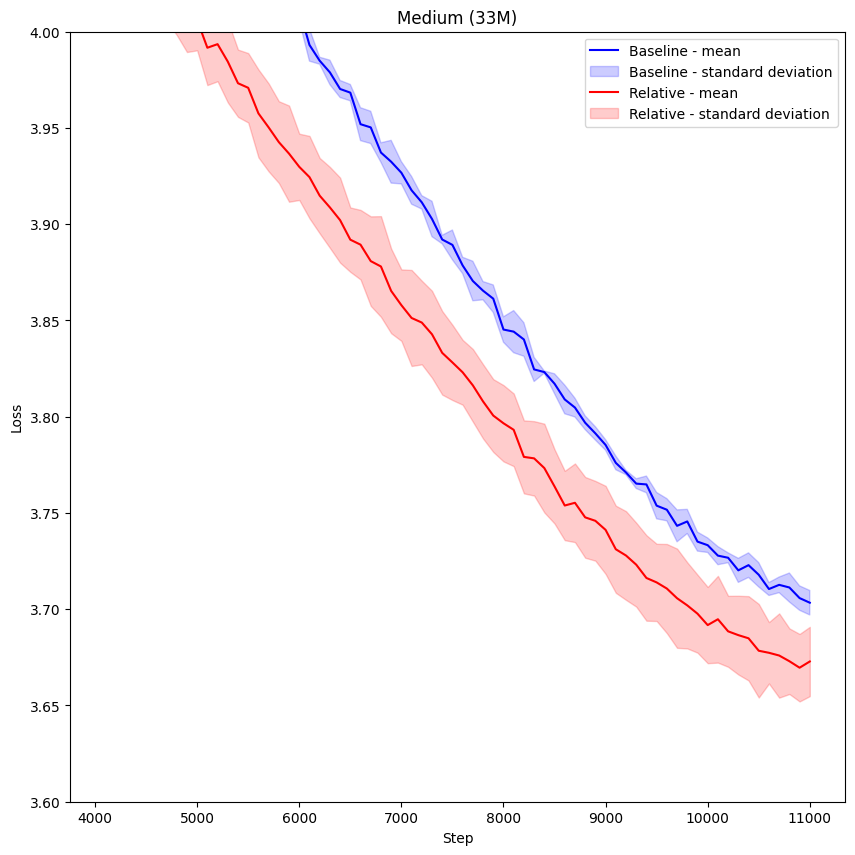

In [51]:
b_v_r_tags_baseline = ['relative_lr', 'relative_vs_baseline', 'medium', 'baseline']
b_v_r_tags_relative = ['relative_lr', 'relative_vs_baseline', 'medium', 'relative']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), gain = plot_std(
    runs_spec_type='tags',
    runs_1=b_v_r_tags_baseline,
    runs_2=b_v_r_tags_relative,
    title='Medium (33M)',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='medium_relative_vs_baseline.png',
    ylim=(3.6, 4),
    x_start=4000,
)

In [52]:
print(f'gain: {100 - gain}')
tokens_per_step = 128 * 512
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000, 0)}M, relative tokens: {round(relative_steps * tokens_per_step / 1000000, 0)}M')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

gain: 10.909999999999997
total tokens: 721.0M, relative tokens: 642.0M
std baseline: 0.0063629323396516895, std relative: 0.018001053673316125


### Base

https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 537)
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 537)
run ID: LLMRANDOM-13685
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13685
run ID: LLMRANDOM-13684
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13684
run ID: LLMRANDOM-13683
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13683
run ID: LLMRANDOM-13682
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13682
run ID: LLMRANDOM-13681
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13681
run ID: LLMRANDOM-13680
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13680


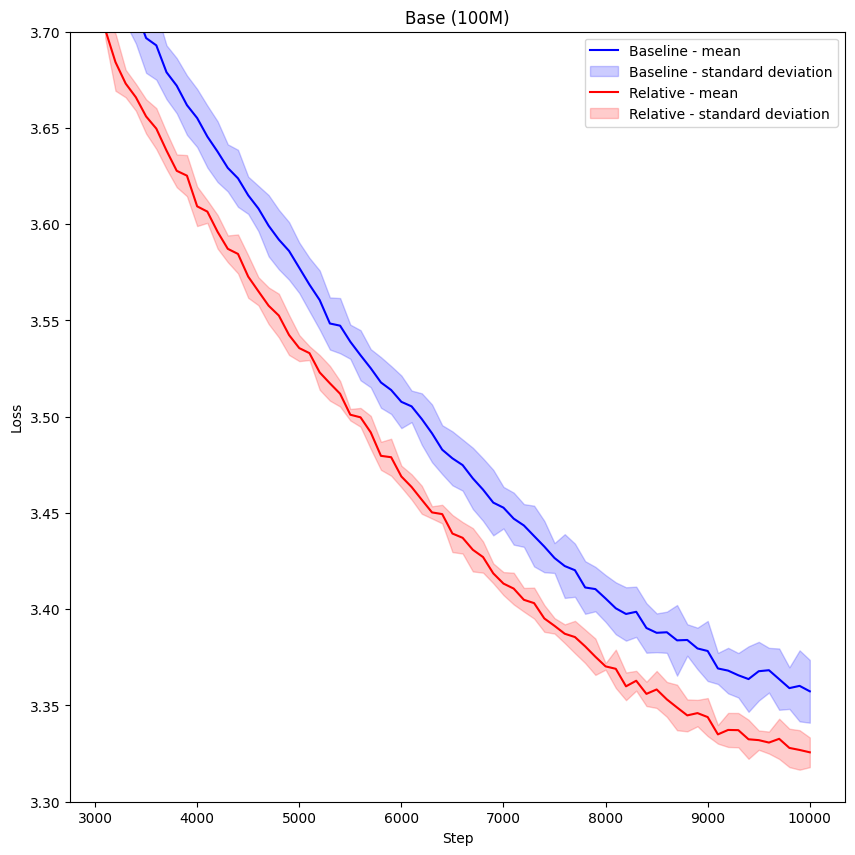

In [53]:
b_v_r_tags_baseline = ['relative_lr', 'relative_vs_baseline', 'base', 'baseline']
b_v_r_tags_relative = ['relative_lr', 'relative_vs_baseline', 'base', 'relative']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), gain = plot_std(
    runs_spec_type='tags',
    runs_1=b_v_r_tags_baseline,
    runs_2=b_v_r_tags_relative,
    title='Base (100M)',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='base_relative_vs_baseline.png',
    ylim=(3.3, 3.7),
    x_start=3000,
)

In [54]:
print(f'gain: {100 - gain}')
tokens_per_step = 256 * 1024
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000000, 2)}B, relative tokens: {round(relative_steps * tokens_per_step / 1000000000, 2)}B')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

gain: 16.0
total tokens: 2.62B, relative tokens: 2.2B
std baseline: 0.016305231637389134, std relative: 0.007711703276944668


## Dense

### Medium

https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 301)
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 301)
run ID: LLMRANDOM-14025
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14025
run ID: LLMRANDOM-14024
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14024
run ID: LLMRANDOM-14023
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14023
run ID: LLMRANDOM-14022
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14022
run ID: LLMRANDOM-14021
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14021
run ID: LLMRANDOM-14020
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14020


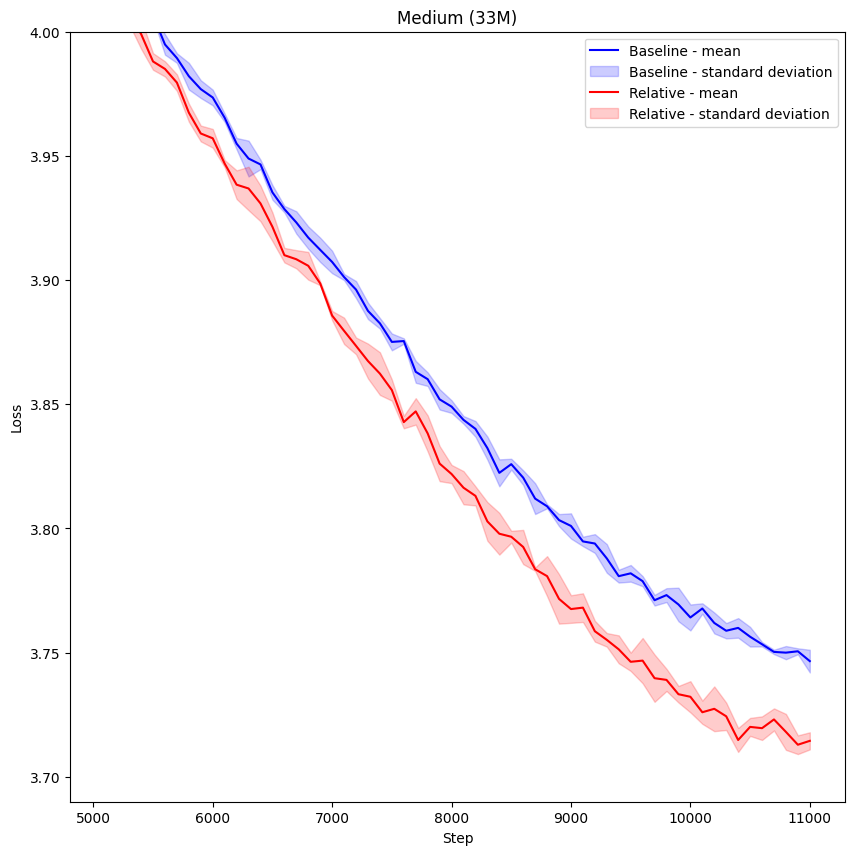

In [55]:
b_v_r_tags_baseline = ['dense', 'std', 'medium', 'baseline']
b_v_r_tags_relative = ['dense', 'std', 'medium', 'relative']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), gain = plot_std(
    runs_spec_type='tags',
    runs_1=b_v_r_tags_baseline,
    runs_2=b_v_r_tags_relative,
    title='Medium (33M)',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='medium_dense_relative_vs_baseline.png',
    ylim=(3.69, 4),
    x_start=5000,
)

In [56]:
print(f'gain: {100 - gain}')
tokens_per_step = 128 * 512
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000, 0)}M, relative tokens: {round(relative_steps * tokens_per_step / 1000000, 0)}M')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

gain: 13.64
total tokens: 721.0M, relative tokens: 623.0M
std baseline: 0.004564642509101271, std relative: 0.0034458252248241463


### Base

https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 352)
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 352)
run ID: LLMRANDOM-14045
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14045
run ID: LLMRANDOM-14044
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14044
run ID: LLMRANDOM-14043
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14043
run ID: LLMRANDOM-14040
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14040
run ID: LLMRANDOM-14039
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14039
run ID: LLMRANDOM-14038
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-14038


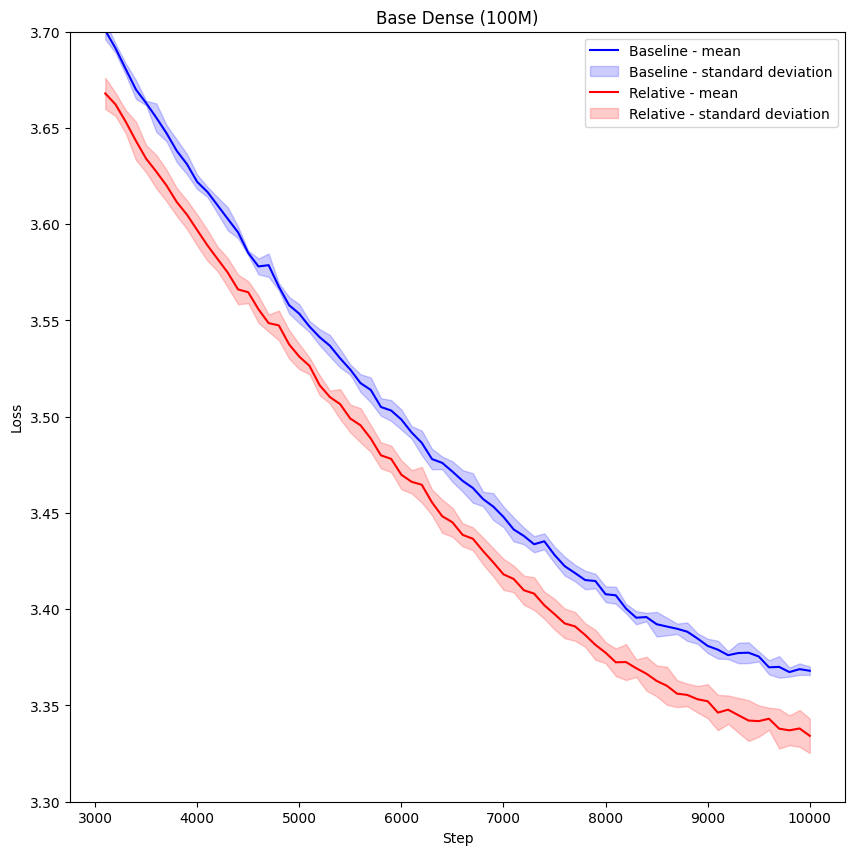

In [57]:
b_v_r_tags_baseline = ['dense', 'std', 'base', 'baseline']
b_v_r_tags_relative = ['dense', 'std', 'base', 'relative']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), gain = plot_std(
    runs_spec_type='tags',
    runs_1=b_v_r_tags_baseline,
    runs_2=b_v_r_tags_relative,
    title='Base Dense (100M)',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='base_dense_relative_vs_baseline.png',
    ylim=(3.3, 3.7),
    x_start=3000,
)

In [58]:
print(f'gain: {100 - gain}')
tokens_per_step = 256 * 1024
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000000, 2)}B, relative tokens: {round(relative_steps * tokens_per_step / 1000000000, 2)}B')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

gain: 16.0
total tokens: 2.62B, relative tokens: 2.2B
std baseline: 0.002189126999109278, std relative: 0.008938206974454375


# U-plot std medium

In [66]:
std_medium_tags = ['relativity_paper', 'medium_model', 'uplot']
std_medium_negative_tags = ['remove']
std_medium_df = get_neptune_table(tags=std_medium_tags, negative_tags=std_medium_negative_tags)

https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (264, 3327)


component_name: embedding_layer, start_end: start
x_values: [ 0.06  0.08  0.12  0.25  0.62  0.83  1.25  2.    2.5   3.    4.   10.
 20.   30.   40.    1.  ]
component_name: embedding_layer, start_end: end
x_values: [0.08 0.11 0.17 0.33 1.33 2.66 4.   5.33]
component_name: head, start_end: start
x_values: [0.08 0.11 0.17 0.33 1.33 2.66 4.   5.33]
component_name: head, start_end: end
x_values: [0.06 0.07 0.11 0.22 0.89 1.78 2.66 3.55]
component_name: gating, start_end: start
x_values: [0.08 0.11 0.17 0.33 1.33 2.66 4.   5.33]
component_name: gating, start_end: end
x_values: [0.12 0.17 0.25 0.5  2.   4.   6.   8.  ]
component_name: expert_inner_function, start_end: start
x_values: [0.04 0.05 0.08 0.15 0.6  1.2  1.8  2.4 ]
component_name: expert_inner_function, start_end: end
x_values: [0.14 0.19 0.28 0.56 2.25 4.5  6.75 9.  ]
component_name: projection, start_end: start
x_values: [0.12 0.17 0.25 0.5  2.   4.   6.   8.  ]
component_name: projection, start_end: end
x_values: [0.12 0.17 0.25

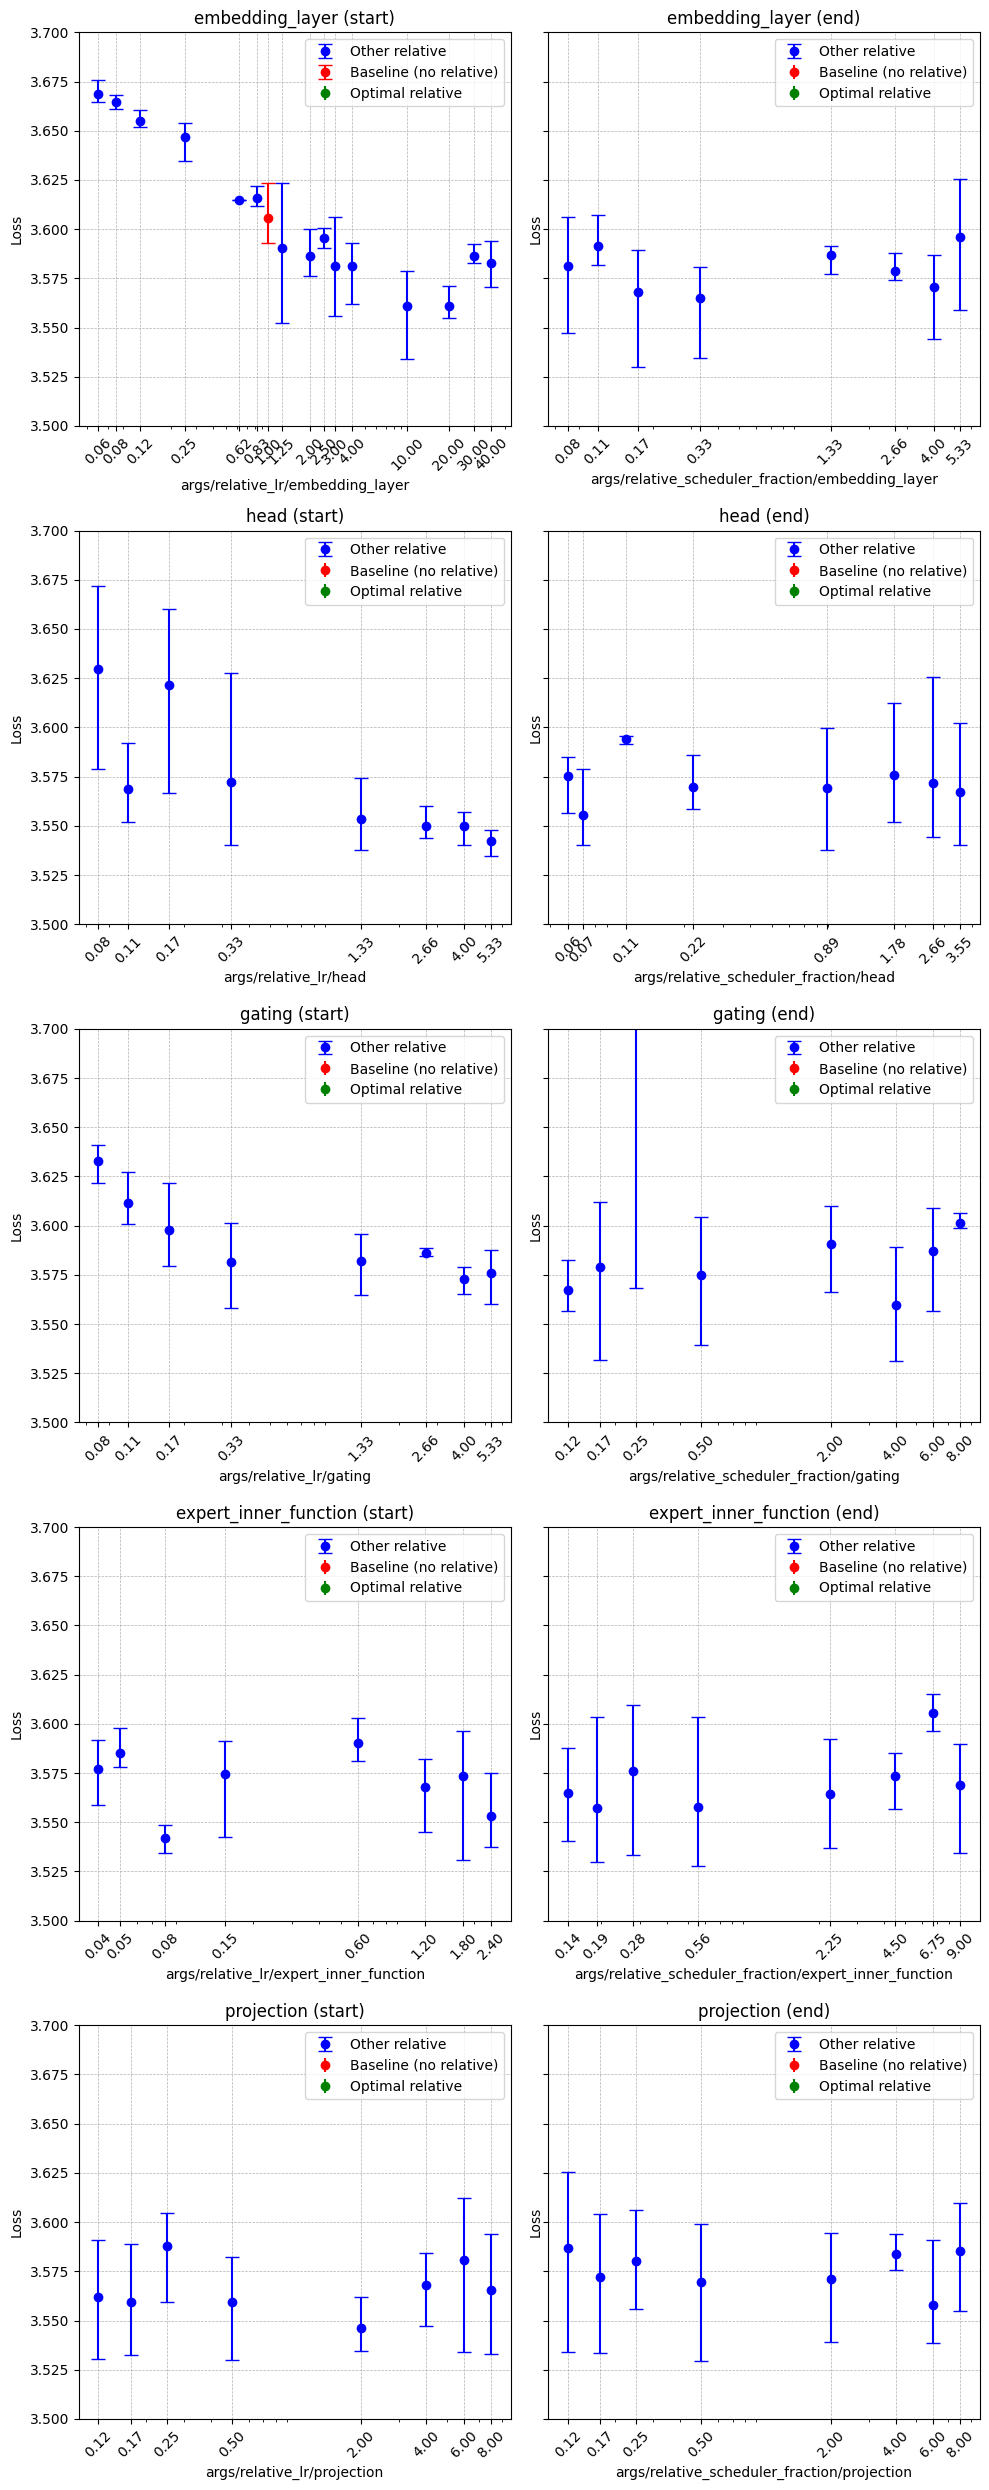

In [67]:
std_medium_tags = ['relativity_paper', 'medium_model', 'uplot']
std_medium_negative_tags = ['remove']
std_medium_df = get_neptune_table(tags=std_medium_tags, negative_tags=std_medium_negative_tags)

component_names = ['embedding_layer', 'head', 'gating', 'expert_inner_function', 'projection']
start_ends = ['start', 'end']

# Create subplots with 2 rows and 5 columns
fig, axs = plt.subplots(len(component_names), len(start_ends), sharey=True, figsize=(10, 25))

# Loop through components and start_ends
for i, name in enumerate(component_names):
    for j, start_end in enumerate(start_ends):
        ax = axs[i, j]
        plot_std_component(table=std_medium_df, component_name=name, start_end=start_end, ax=ax)
        ax.set_title(f'{name} ({start_end})')
        for label in ax.get_xticklabels():
            label.set_rotation(45)

for ax in axs.flat:
    ax.set_ylim(3.5, 3.7)

# Adjust layout to make room for labels
plt.tight_layout()
plt.savefig('U-plots-std.png')
plt.show()

component_name: embedding_layer, start_end: start
x_values: [ 0.06  0.08  0.12  0.25  0.62  0.83  1.25  2.    2.5   3.    4.   10.
 20.   30.   40.    1.  ]


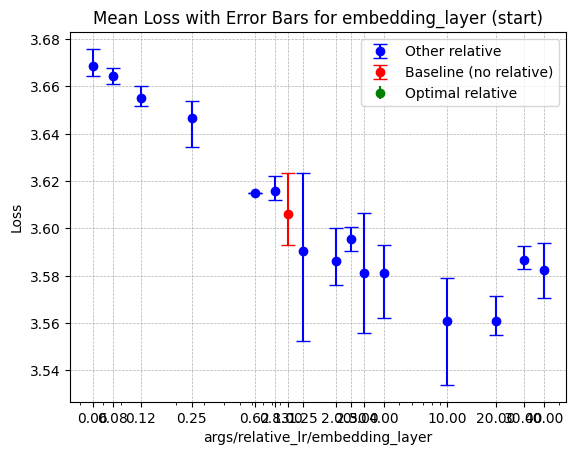

In [62]:
plot_std_component(table=std_medium_df, component_name="embedding_layer", start_end="start")


# Component ablations

https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 368)
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (3, 368)
run ID: LLMRANDOM-13826
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13826
run ID: LLMRANDOM-13825
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13825
run ID: LLMRANDOM-13824
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13824
run ID: LLMRANDOM-13677
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13677
run ID: LLMRANDOM-13674
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13674
run ID: LLMRANDOM-13563
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13563
gain: 12.730000000000004
ablation loss: 3.712037760416667
baseline loss: 3.36802734375


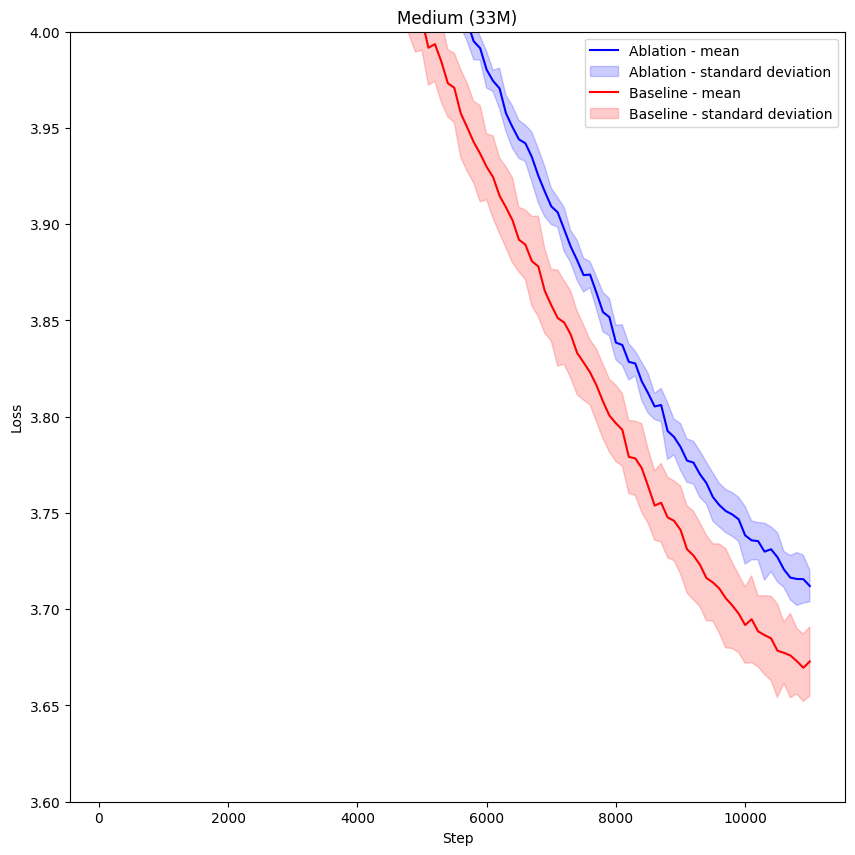

In [63]:
# component_name = 'expert_inner_function'
# component_name = 'gating'
component_name = 'head'
# component_name = 'embedding_layer'

comp_abl = ['relative_lr', 'medium', 'component_ablations', component_name]
comp_abl_baseline = ['relative_lr', 'medium', 'component_ablations', 'relative']

(all_steps, ablation_loss, _), (relative_steps, relative_loss, _), gain = plot_std(
    runs_spec_type='tags',
    runs_1=comp_abl,
    runs_2=comp_abl_baseline,
    title='Medium (33M)',
    name_1='Ablation',
    name_2='Baseline',
    show_plot=False,
    # save_to=f'component_ablations_{component_name}.png',
    ylim=(3.6, 4)
)
print(f'gain: {100 - gain}')
print(f'ablation loss: {ablation_loss}')
print(f'baseline loss: {baseline_loss}')

In [64]:
print(f'gain: {100 - gain}')
tokens_per_step = 128 * 512
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000, 0)}M, relative tokens: {round(relative_steps * tokens_per_step / 1000000, 0)}M')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

gain: 12.730000000000004
total tokens: 721.0M, relative tokens: 629.0M
std baseline: 0.002189126999109278, std relative: 0.008938206974454375


# BIG models

### MoE

In [65]:
b_v_r_tags_baseline = ['large_extrapolation', 'seq_len_1024', 'sota', 'baseline']
b_v_r_tags_relative = ['large_extrapolation', 'seq_len_1024', 'sota', 'relative']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), gain = plot_std(
    runs_spec_type='tags',
    tags_1=b_v_r_tags_baseline,
    tags_2=b_v_r_tags_relative,
    title='1B',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='1Brelative_vs_baseline.png',
    ylim=(2.7, 3.5),
    # x_start=3000,
    loss_per=1000,
)

TypeError: plot_std() got an unexpected keyword argument 'tags_1'

In [94]:
print(f'gain: {100 - gain}')
tokens_per_step = 384 * 1024
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000000, 2)}B, relative tokens: {round(relative_steps * tokens_per_step / 1000000000, 2)}B')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

gain: 24.0
total tokens: 19.66B, relative tokens: 14.94B
std baseline: 0.0, std relative: 0.0


### Dense

https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (1, 476)
run ID: LLMRANDOM-13393
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13393
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (1, 492)
run ID: LLMRANDOM-13404
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13404


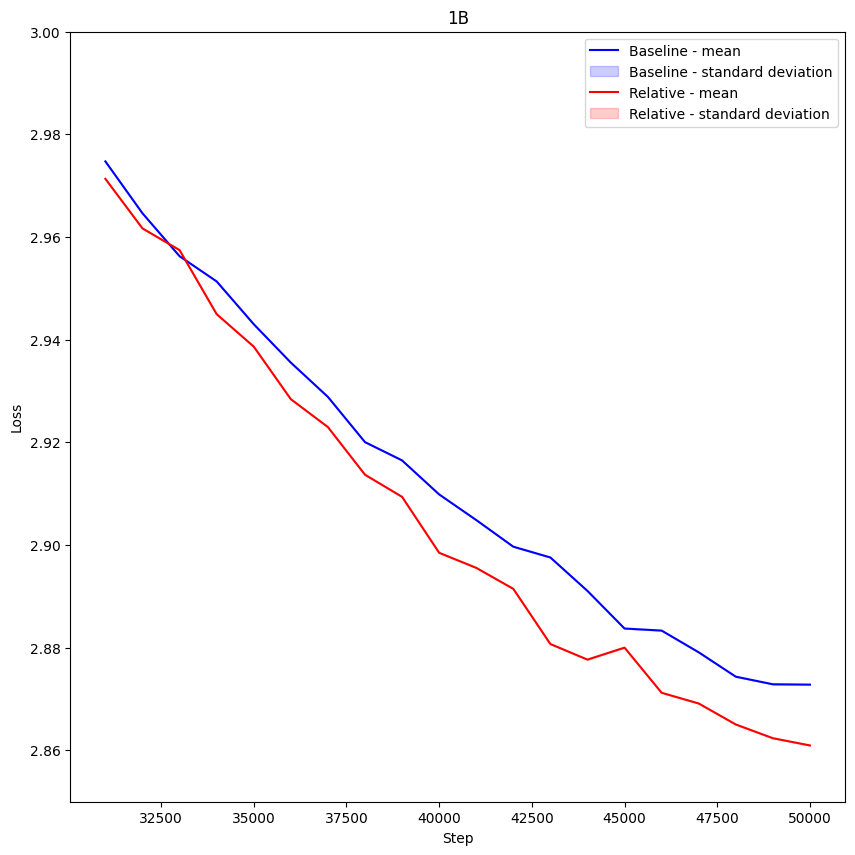

In [101]:
b_v_r_tags_baseline = ['large_extrapolation', 'dense', 'sota', 'baseline']
b_v_r_tags_relative = ['large_extrapolation', 'dense', 'sota', 'relative']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), gain = plot_std(
    tags_1=b_v_r_tags_baseline,
    tags_2=b_v_r_tags_relative,
    title='1B',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to='1Brelative_vs_baseline.png',
    ylim=(2.85, 3),
    x_start=30000,
    loss_per=1000,
)

In [102]:
print(f'gain: {100 - gain}')
tokens_per_step = 384 * 1024
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000000, 2)}B, relative tokens: {round(relative_steps * tokens_per_step / 1000000000, 2)}B')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

gain: 8.0
total tokens: 19.66B, relative tokens: 18.09B
std baseline: 0.0, std relative: 0.0


### Overtrain

https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (1, 509)
run ID: LLMRANDOM-13351
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13351
https://app.neptune.ai/pmtest/llm-random/
table downloaded
shape: (1, 519)
run ID: LLMRANDOM-13349
https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-13349


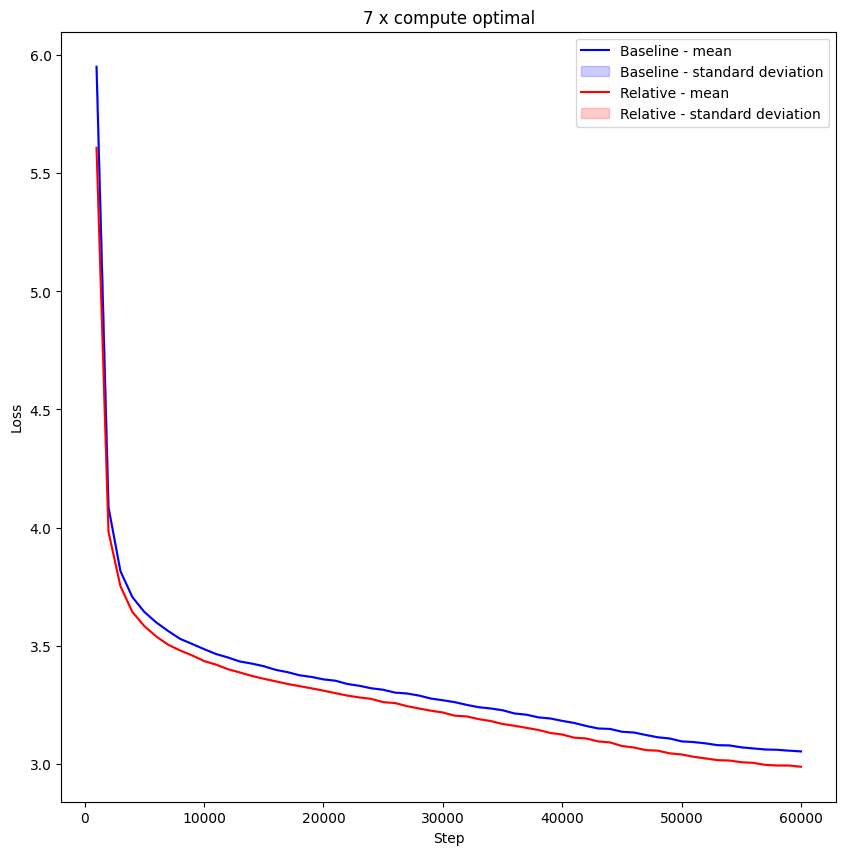

In [106]:
num = 7
b_v_r_tags_baseline = ['base_extrapolation', 'long', 'relative_lr', f'{num}xcmpt_opt', 'baseline']
b_v_r_tags_relative = ['base_extrapolation', 'long', 'relative_lr', f'{num}xcmpt_opt', 'relative']

(all_steps, baseline_loss, baseline_std), (relative_steps, relative_loss, relative_std), gain = plot_std(
    tags_1=b_v_r_tags_baseline,
    tags_2=b_v_r_tags_relative,
    title=f'{num} x compute optimal',
    name_1='Baseline',
    name_2='Relative',
    show_plot=True,
    save_to=f'{num}xcmpt_opt_relative_vs_baseline.png',
    # ylim=(2.85, 3),
    # x_start=30000,
    loss_per=1000,
)

In [107]:
print(f'gain: {100 - gain}')
tokens_per_step = 384 * 1024
print(f'total tokens: {round(all_steps * tokens_per_step / 1000000000, 2)}B, relative tokens: {round(relative_steps * tokens_per_step / 1000000000, 2)}B')
print(f'std baseline: {baseline_std}, std relative: {relative_std}')

gain: 18.33
total tokens: 23.59B, relative tokens: 19.27B
std baseline: 0.0, std relative: 0.0
